# MLG - Practical Work 02
## Natural men voices vs. natural children voices

In [1]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav
from python_speech_features import mfcc
import numpy
import mlp_backprop_momentum as mlp
import sys
from ipywidgets import interact, widgets
import k_fold_cross_validation as cv

%matplotlib inline

## Global constants

These constants define the path where the audio files are located and which experiment to perform.

In [6]:
# PATH = '/home/arthur/Projects/MLG_Labs/pw2/vowels/'
PATH = '/home/arthy/Documents/MLG_Labs/pw2/vowels/'

EXPERIMENTS = [['nam', 'naf'], ['nam', 'nk'], ['naf', 'nk'], ['naf', 'nam', 'nk'], ['n', 's']]
EXPERIMENT = EXPERIMENTS[1]

The function `getFullDataset` takes the path where the audio files are located as first argument.
The `pops` argument is an array of strings that defines the files to analyse.

It returns a tuple containing the normalized data for each class and the full normalized dataset.

In [7]:
def getFullDataSet(path, pops):
    
    files   = [[] for i in range(len(pops))]
    ceps    = [[] for i in range(len(pops))]
    classes = [[] for i in range(len(pops))]

    for i in os.listdir(path):
        for j in range(len(pops)):
            if os.path.isfile(os.path.join(path, i)) and pops[j] in i:
                files[j].append(i)

    for i in range(len(ceps)):
        for j in range(len(files[i])):
            sample_rate, X = wav.read(os.path.join(path, files[i][j]))
            if len(ceps[i]) == 0:
                ceps[i] = mfcc(X, samplerate=sample_rate, nfft=1024, numcep=13)
            else:
                ceps[i] = np.concatenate((ceps[i], mfcc(X, samplerate=sample_rate, nfft=1024, numcep=13)), axis=0)
            
    ceps_total = np.concatenate([ceps[i] for i in range(len(pops))])
    
    # Normalize values.
    medians = np.median(ceps_total, axis=0)
    ceps_total = np.subtract(ceps_total, medians)
    maxs = numpy.max(np.abs(ceps_total), axis=0)
    mins = numpy.min(np.abs(ceps_total), axis=0)    
    ceps_total = np.divide(ceps_total, maxs - mins)
    
    # Append 'class' column.
    classes_row = np.identity(len(ceps))
    for i in range(len(ceps)):
        # Duplicate identity rows to corresponding ceps class length
        classes[i] = np.tile(classes_row[i], (len(ceps[i]), 1))
    
    # Initialize array to allow concatenation
    class_total = classes[0]
    # Concatenate all classes array (1st one already done)
    for i in range(len(pops) - 1):
        class_total = np.concatenate((class_total, classes[i+1]), axis=0)
 
    # Concatenate columns to total ceps dataset
    ceps_total = np.concatenate((ceps_total, class_total), axis=1)

    medians = [[] for i in range(len(ceps))]
    mins    = [[] for i in range(len(ceps))]
    maxs    = [[] for i in range(len(ceps))]
    for i in range(len(ceps)):
        medians[i] = np.median(ceps[i], axis=0)
        ceps[i] = np.subtract(ceps[i], medians[i])
        mins[i] = np.min(np.abs(ceps[i]), axis=0)
        maxs[i] = np.max(np.abs(ceps[i]), axis=0)
        ceps[i] = np.divide(ceps[i], maxs[i] - mins[i])
    
    for i in range(len(ceps)):
        ceps[i] = np.concatenate((ceps[i], classes[i]), axis=1)
                                                                
    return [ceps[i] for i in range(len(ceps))], ceps_total

## Dataset

We display the boxplots of the different classes and the full dataset to verify that data is coherent.

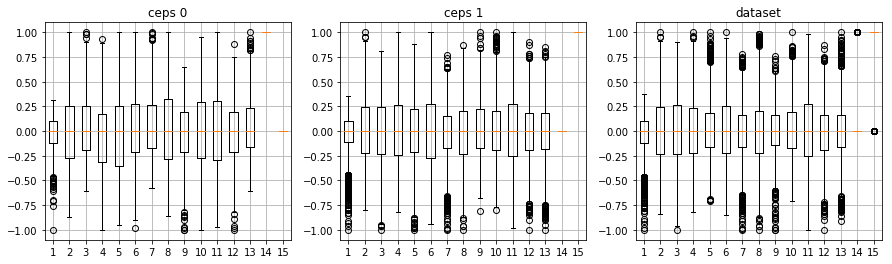

In [8]:
# Retrieve dataset.
ceps, dataset = getFullDataSet(PATH, EXPERIMENT)

pl.figure(figsize=(15,4))
for i in range(len(ceps)):
    pl.subplot(1,len(ceps)+1,i+1)
    pl.boxplot(ceps[i])
    pl.title('ceps '+ str(i))
    pl.grid()
pl.subplot(1,len(ceps)+1,len(ceps)+1)
pl.boxplot(dataset)
pl.title('dataset')
pl.grid()

## Exploring the number of epochs

Then, we want to find how many iterations are of the backpropagation algorithm are enough to find a low training error.

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


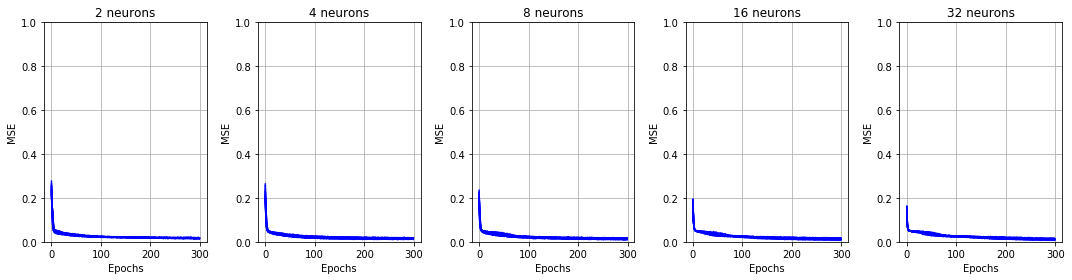

In [9]:
# Try to find how many iterations are enough.
N_INITS = 10
EPOCHS = 300
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5
INPUT_NEURONS = dataset.shape[1] - len(ceps)
OUTPUT_NEURONS = len(ceps)

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([INPUT_NEURONS, h, OUTPUT_NEURONS], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:, 0:INPUT_NEURONS], dataset[:, INPUT_NEURONS:INPUT_NEURONS+OUTPUT_NEURONS]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

For the cases where 2 to 8 neurons are used in the hidden layer, the training error is quite disparate. For 16 and 32 neurons, we see that after 150 iterations, there are no significant improvements.

The minimum number of iterations needed is 150.

## Exploring the number of hidden neurons

We can now explore how the number of hidden neurons is linked to the test error. Since we previously stated that 2 to 8 neurons don't give results good enough, we start from 10 hidden neurons and end at 30.

In [10]:
# Now that we know 150 iterations are enough, let's find out how many hidden neurons we need.
EPOCHS = 300
K = 5
N_TESTS = 10
# Relevant values. TODO: explain in report.
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([INPUT_NEURONS, h, OUTPUT_NEURONS], 'tanh')
    for i in np.arange(N_TESTS):
        nn.init_weights()
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                            dataset,
                                                            k=K,
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...


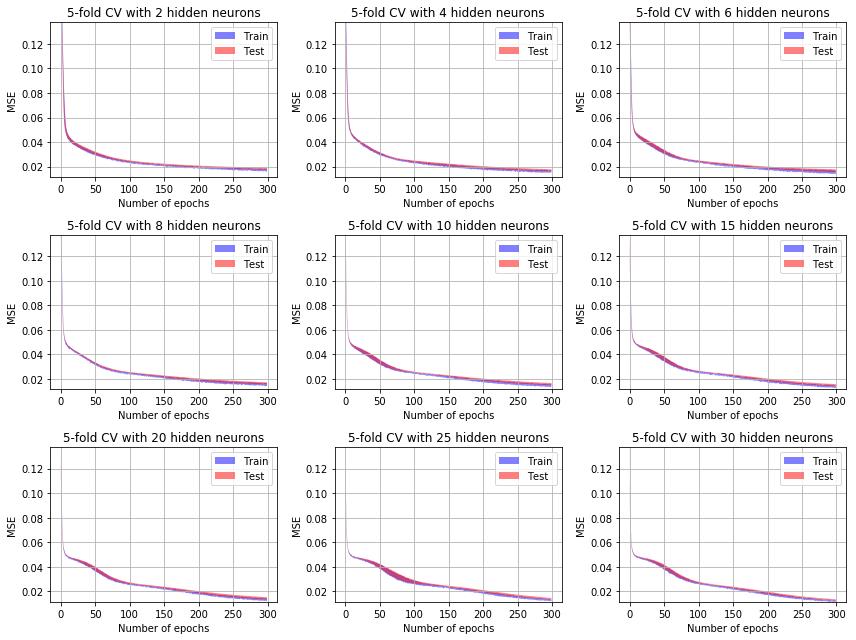

In [11]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

We notice that after 125 iterations, the test error does not improve, neither adding more hidden neurons after 10.

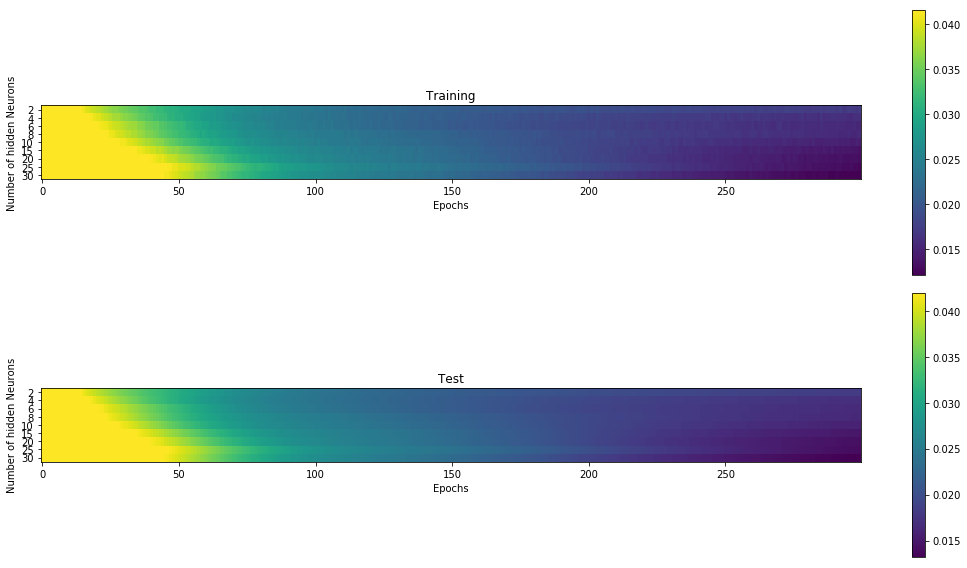

In [12]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

For this particular problem, having more hidden neurons or running the backpropagation algorithm longer does not affect negatively the performance of the model. However, more iterations implies more processing time and more neurons implies more ressources and this should be avoided.

In [ ]:
EPOCHS = 300
N_NEURONS = 32

nn = mlp.MLP([INPUT_NEURONS, N_NEURONS, OUTPUT_NEURONS], 'tanh')
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=EPOCHS,
                                                          threshold=0.5)

In [13]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.021371237714398493
MSE test:  0.021825194741781233
Confusion matrix:
[[ 734.   53.]
 [  45. 2846.]]
